# **Entrainer et gérer mes modèles avec MLFLOW**

### **Librairies nécessaires**

In [33]:
# libriaries nécessaires pour la manipulation
import numpy as np
import pandas as pd
# Pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Encodage des variables catégorielles et normalisation des variables numériques
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer # Gérer les NaNs

# Split du dataset et validation croisée
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modèles de classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import mlflow.lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Métriques d'évaluation
from sklearn.metrics import classification_report, roc_auc_score, f1_score, fbeta_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import KFold # Pour diviser le dataset en pli


import gc  # Pour libérer la mémoire
import os # Gestion du système de fichiers du drive

# Supprimer les avertissements
import warnings
warnings.filterwarnings('ignore')

import joblib

**Chargement des données**

In [34]:
# %%
# Chargement des données
data = pd.read_pickle('train_red_format.pkl')
print('Dimension des données: ', data.shape)
data.head()


Dimension des données:  (244774, 14)


,SK_ID_CURR,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_mean,bureau_CREDIT_ACTIVE_Closed_mean,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,bureau_CREDIT_ACTIVE_Active_mean
0,100002,1,0.139404,0.262939,-9461.0,-103.0,-1437.0,-500.0,-874.0,0.750000,Cash loans,M,N,0.250000
2,100004,0,0.729492,0.556152,-19046.0,-408.0,-1326.0,-532.0,-867.0,1.000000,Revolving loans,M,Y,0.000000
5,100008,0,0.621094,0.354248,-16941.0,-78.0,-1097.0,-611.0,-757.5,0.666504,Cash loans,M,N,0.333252
6,100009,0,0.491943,0.724121,-13778.0,-239.0,-2882.0,-851.5,-1272.0,0.777832,Cash loans,F,Y,0.222168
7,100010,0,0.540527,0.714355,-18850.0,-1138.0,-2740.0,-578.0,-1940.0,0.500000,Cash loans,M,Y,0.500000


**Pre-processing**

In [35]:
# Séparer les colonnes numériques et catégoriques
df = data.copy()
categorical_cols = df.select_dtypes(include = "object").columns
numeric_cols = df.drop(['TARGET', 'SK_ID_CURR'], axis = 1).select_dtypes(exclude = "object").columns

print(numeric_cols)
print(categorical_cols)

# %%
# Encodage des catégorielles avec One-Hot
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.info()

# %%
df['NAME_CONTRACT_TYPE_Revolving loans'].unique()


# %% Normalisation des données numériques
# Instancier le scaler
scaler = MinMaxScaler()

# Normaliser uniquement les colonnes numériques
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'bureau_DAYS_CREDIT_max',
       'bureau_DAYS_CREDIT_min', 'bureau_DAYS_CREDIT_UPDATE_mean',
       'bureau_DAYS_CREDIT_mean', 'bureau_CREDIT_ACTIVE_Closed_mean',
       'bureau_CREDIT_ACTIVE_Active_mean'],
      dtype='object')
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 244774 entries, 0 to 307510
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   SK_ID_CURR                          244774 non-null  int32  
 1   TARGET                              244774 non-null  int8   
 2   EXT_SOURCE_3                        244774 non-null  float16
 3   EXT_SOURCE_2                        244774 non-null  float16
 4   DAYS_BIRTH                          244774 non-null  float32
 5   bureau_DAYS_CREDIT_max              244774 non-null  float16
 6   bu

#### **Spliter le dataset**

In [36]:
# Séparation X (features) et y (cible)
X = df.drop(columns=['TARGET'])  # Exclure la cible et l'identifiant client
y = df['TARGET']

seed = 123
# Division en jeux d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y  # Stratify pour garder le déséquilibre
)

print(f"Taille du jeu d'entraînement : {X_train.shape}")
print(f"Taille du jeu de test : {X_test.shape}")

Taille du jeu d'entraînement : (195819, 14)
Taille du jeu de test : (48955, 14)


### **Entrainement**

**Modèle LGBMClassifier**

In [44]:
# Définir le modèle et les hyperparamètres
lgbm = LGBMClassifier(class_weight={0: 1, 1: 10}, # Poids des classes
                      random_state=seed
                      )

param_grid_lgbm = {
    'num_leaves': [31, 50],
    'max_depth': [10, 15],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

# GridSearch avec Cross-Validation
grid_lgbm = GridSearchCV(estimator=lgbm,
                         param_grid=param_grid_lgbm, # Hyperparamètres
                         scoring='f1', # Métrique d'évaluation
                         cv=3, # Nombre de folds de la validation croisée
                         n_jobs=-1
                         )


In [45]:
# Entraînement
grid_lgbm.fit(X_train, y_train)

# Résultats
best_lgbm_params = grid_lgbm.best_params_ # Meilleurs hyperparamètres
best_lgbm_score = grid_lgbm.best_score_ # Meilleur score F1
print(f"LightGBM - Best Params: {best_lgbm_params}, Best F1-Score: {best_lgbm_score:.4f}")


2025/01/07 01:27:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8b28a1c4f86040bfb200587d4f30728c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15214, number of negative: 180605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2308
[LightGBM] [Info] Number of data points in the train set: 195819, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457227 -> initscore=-0.171511
[LightGBM] [Info] Start training from score -0.171511
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

2025/01/07 01:31:29 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.


LightGBM - Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 31}, Best F1-Score: 0.2663


**Modèle de Regression Logistique**

In [46]:
# Définir le modèle
log_reg = LogisticRegression(max_iter=200, class_weight={0: 1, 1: 10}, solver='liblinear', random_state=seed)

# Définir la grille des hyperparamètres
param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100], # Inverse de la force de régularisation
    'penalty': ['l1', 'l2'] # Norme de pénalisation
}

# GridSearch avec Cross-Validation
grid_log = GridSearchCV(estimator=log_reg
                        , param_grid=param_grid_log
                        , scoring='f1'
                        , cv=5
                        , n_jobs=-1)

In [47]:
# Entraînement
grid_log.fit(X_train, y_train)

# Résultats
best_log_params = grid_log.best_params_
best_log_score = grid_log.best_score_
print(f"Régression Logistique - Best Params: {best_log_params}, Best F1-Score: {best_log_score:.4f}")


2025/01/07 08:27:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cb898772ebcd4e6c8ff9a4fae305adcb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/07 08:32:42 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


Régression Logistique - Best Params: {'C': 100, 'penalty': 'l1'}, Best F1-Score: 0.2613


**Le RandomForest**

In [48]:
# Définition du modèle et des hyperparamètres
rf = RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=seed)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearch avec Cross-Validation
grid_rf = GridSearchCV(estimator=rf
                       , param_grid=param_grid_rf
                       , scoring='f1'
                       , cv=5
                       , n_jobs=-1)

In [49]:
# Entraînement du modèle
grid_rf.fit(X_train, y_train)

# Résultats
best_rf_params = grid_rf.best_params_
best_rf_score = grid_rf.best_score_
print(f"Random Forest - Best Params: {best_rf_params}, Best F1-Score: {best_rf_score:.4f}")


2025/01/07 08:38:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f172f369db1e4f83a3f5a57efc945539', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/01/07 22:00:34 INFO mlflow.sklearn.utils: Logging the 5 best runs, 76 runs will be omitted.


Random Forest - Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}, Best F1-Score: 0.2749


In [54]:
model = lgb.LGBMClassifier(
    class_weight={0: 1, 1: 10}, # Poids des classes 
    learning_rate = 0.1,
    max_depth = 15, 
    n_estimators= 200, 
    num_leaves=30,
    random_state=seed
)
# Entraîner le modèle
model.fit(X_train, y_train)

2025/01/07 23:36:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a7906f2884944b6190a06e81365b2923', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15214, number of negative: 180605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2308
[LightGBM] [Info] Number of data points in the train set: 195819, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457227 -> initscore=-0.171511
[LightGBM] [Info] Start training from score -0.171511


LGBMClassifier(class_weight={0: 1, 1: 10}, max_depth=15, n_estimators=200,
               num_leaves=30, random_state=123)

In [55]:
# Prédictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilité pour la classe 1

In [73]:
X_test

,SK_ID_CURR,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_mean,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_ACTIVE_Active_mean,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y
191642,322210,0.832599,0.737864,0.122682,0.841205,0.140411,0.967114,0.429110,0.888672,0.000000,False,False,False,False
183535,312732,0.363931,0.740148,0.080171,0.981520,0.748288,0.996695,0.901712,0.500000,0.500000,False,False,False,False
229083,365338,0.488800,0.582524,0.078916,0.964408,0.005479,0.974178,0.517466,0.714355,0.285645,False,False,False,False
161049,286694,0.835871,0.854940,0.650442,0.431211,0.151370,0.988843,0.291096,1.000000,0.000000,False,True,False,False
88672,202954,0.576863,0.681324,0.840685,0.549623,0.128082,0.982113,0.339041,1.000000,0.000000,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118750,237705,0.860954,0.698458,0.579515,0.731691,0.236301,0.982889,0.459589,0.833496,0.166626,False,False,False,False
83242,196548,0.534876,0.881211,0.753609,0.956879,0.616781,0.997260,0.833647,0.600098,0.399902,False,False,False,False
238898,376730,0.492889,0.545973,0.362682,0.934976,0.592466,0.989702,0.758390,0.250000,0.750000,False,False,False,False
239959,377876,0.803154,0.366932,0.245649,0.912389,0.115068,0.983175,0.494521,0.500000,0.500000,False,False,False,False


**Evaluation du modèle**

**1. Classification report**

In [56]:
# Classification report
print("Classification Report :\n", classification_report(y_test, y_pred))

Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     45152
           1       0.17      0.57      0.26      3803

    accuracy                           0.75     48955
   macro avg       0.56      0.67      0.56     48955
weighted avg       0.89      0.75      0.80     48955



**2. Matrice de confusion**

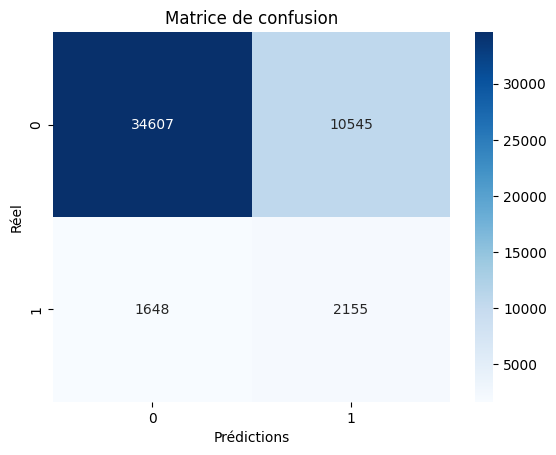

In [57]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show();

**3. Courbe ROC et AUC**

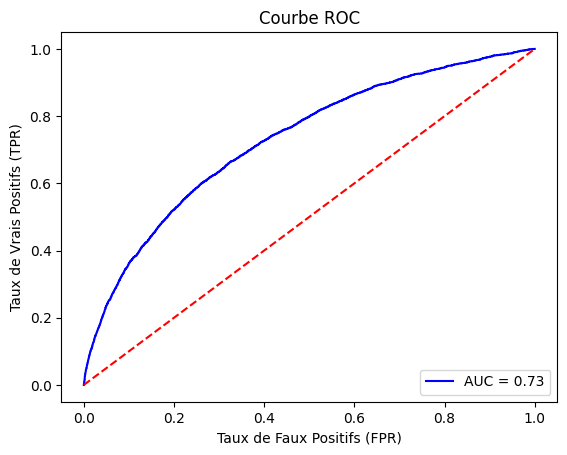

In [58]:
# Courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.show();

# UN AUC-ROC de 0.74 montre que les classes sont bien séparées

**4. Courbe Précision-Rappel**

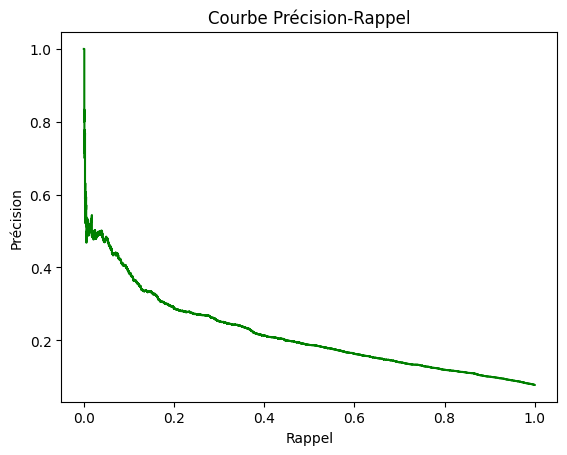

In [36]:
# Courbe Précision-Rappel
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, color='green')
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.show();

**5. Évaluation avec F2 et F3**

In [59]:
# %% Évaluation avec les métriques F2 et F3

f2 = fbeta_score(y_test, y_pred, beta=2)  # F2-score
f3 = fbeta_score(y_test, y_pred, beta=3)  # F3-score

# Affichage des résultats
print("=== Scores supplémentaires ===")
print(f"F2-score : {f2:.4f}")
print(f"F3-score : {f3:.4f}")

# F2-score : 0.3984
# F3-score : 0.4945
# le score F2 est plus élevé que le F1, ce qui signifie que
# le modèle est plus performant pour la classe minoritaire


=== Scores supplémentaires ===
F2-score : 0.3860
F3-score : 0.4592


**Optimisation des hyperparamètres**

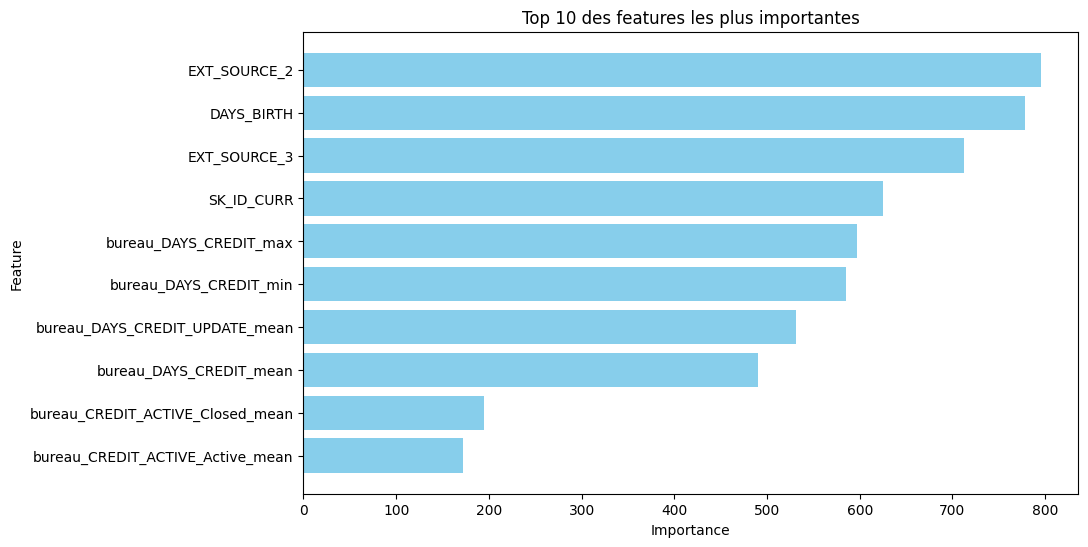

In [60]:
#  Récupérer les importances des features
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

# # Affichage des 10 features les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10][::-1], feature_importances['Importance'][:10][::-1], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 des features les plus importantes")
plt.show();


#### **Réduction des features et réentraînement**

In [61]:
# Liste des 10 features les plus importantes
top_features = feature_importances['Feature'][:10].tolist()

# Sous-ensemble des données d'entraînement et de test
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# # Réinitialisation du modèle avec les meilleurs paramètres trouvés
optimized_model = lgb.LGBMClassifier(
    class_weight={0: 1, 1: 10}, # Poids des classes 
    learning_rate = 0.1,
    max_depth = 15,
    n_estimators= 200, 
    num_leaves=30,
    random_state=seed
)

# Réentraînement
optimized_model.fit(X_train_top, y_train)

# Prédictions
y_pred_top = optimized_model.predict(X_test_top)
y_pred_proba_top = optimized_model.predict_proba(X_test_top)[:, 1]

2025/01/07 23:39:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '079cf11b635344bbb6b2fd65076c8cde', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 15214, number of negative: 180605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 195819, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457227 -> initscore=-0.171511
[LightGBM] [Info] Start training from score -0.171511


In [62]:
# Affichage des performances
f2_top = fbeta_score(y_test, y_pred_top, beta=2)
f3_top = fbeta_score(y_test, y_pred_top, beta=3)
print(f"F2-score (top features) : {f2_top:.4f}")
print(f"F3-score (top features) : {f3_top:.4f}")

F2-score (top features) : 0.3749
F3-score (top features) : 0.4446


In [63]:
print(f2)
print(f3)

0.3860346804241903
0.4592239009525433


**L'écart entre les métriques (f2 et f3) sur 15 caractéristiques et 10 caractériques est de 1 point. Cela veut dire les 10 caractéristiques captent elles seules tout le poids du modèle. Donc, on la modelisation avec ces 10 caractéristiques**

In [41]:
# %% Voir la répartition des vraies et fausses prédictions par classe
## Classification report
report = classification_report(y_test, y_pred_top)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_top)
print("Confusion Matrix:\n", cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84     45152
           1       0.16      0.58      0.25      3803

    accuracy                           0.73     48955
   macro avg       0.56      0.66      0.54     48955
weighted avg       0.89      0.73      0.79     48955

Confusion Matrix:
 [[33671 11481]
 [ 1611  2192]]


In [42]:
# Ajustement du seuil (exemple à 0.3 pour favoriser la classe minoritaire)
y_pred_adjusted = (y_pred_proba_top >= 0.3).astype(int)

# Calcul du F2-score avec le nouveau seuil
f2_adjusted = fbeta_score(y_test, y_pred_adjusted, beta=2)
f3_adjusted = fbeta_score(y_test, y_pred_adjusted, beta=3)
print(f"F2-score avec seuil ajusté : {f2_adjusted:.4f}")
print(f"F3-score avec seuil ajusté : {f3_adjusted:.4f}")

F2-score avec seuil ajusté : 0.3600
F3-score avec seuil ajusté : 0.5011


In [ ]:
# # Sauvegarde du modèle
# joblib.dump(optimized_model, 'lgb_model.pkl')

# # %%# Chargement du modèle
# model_loaded = joblib.load('lgb_model.pkl')

# # Vérification du chargement avec une prédiction
# sample_data = np.array([[0.1, 30, 0.3, 100, 500, 250, 1000, 1, 0, 2]])  # Exemple de données
# prediction = model_loaded.predict(sample_data)
# print("Prédiction du modèle chargé :", prediction)


**Regression Logistique**

In [52]:
# Entraînement du modèle
clf = LogisticRegression(random_state=seed)
clf.fit(X_train, y_train)

2024/12/28 18:13:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '78338c9a951545edbaf02754cc0baf03', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LogisticRegression(random_state=123)

In [53]:
y_pred_clf = clf.predict(X_test)
f2_log = fbeta_score(y_test, y_pred_clf, beta=2)
f3_log = fbeta_score(y_test, y_pred_clf, beta=3)
# y_pred_proba_log = clf.predict_proba(X_test)[:, 1]
print(f"F2-score (Regression Logistique) : {f2_log:.4f}")
print(f"F3-score (Regression Logistique) : {f3_log:.4f}")

# F2-score (Regression Logistique) : 0.0039
# F3-score (Regression Logistique) : 0.0035

F2-score (Regression Logistique) : 0.0039
F3-score (Regression Logistique) : 0.0035


**Tracking avec mlflow**

In [88]:
# # Tracking avec mlflow
# import mlflow
# import mlflow.sklearn
# import mlflow.lightgbm
# from sklearn.metrics import accuracy_score, f1_score
# mlflow.set_experiment("Modeles") # Nom de ma branche

<Experiment: artifact_location='file:///content/mlruns/407454828257027944', creation_time=1735419799132, experiment_id='407454828257027944', last_update_time=1735419799132, lifecycle_stage='active', name='Modeles', tags={}>

**Regression Logistique**

In [89]:
# # Créer mon exécution avec un nom à defaut
# # Appel à l'api de slearn de mlflow qui integre tous les modules de sklearn
# mlflow.sklearn.autolog()

# # Premier run
# with mlflow.start_run(run_name="reg_log_defaut"):
#   # Entraînement du modèle
#   clf = LogisticRegression(random_state=seed)
#   clf.fit(X_train, y_train)


2024/12/28 21:31:29 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [90]:
# # On va faire un second run avec un nombre d'itération max de 200
# with mlflow.start_run(run_name="reg_log_maxiter200"):
#   clf_2 = LogisticRegression(random_state=seed, max_iter = 200)
#   clf_2.fit(X_train, y_train)

**LGBMClassifier**

In [ ]:
# Un troisième run pour le modèle LightGBM avec les paramètres par défaut
# Activation de l'autolog pour LightGBM
mlflow.lightgbm.autolog()

with mlflow.start_run(run_name="lgb_balanced"):
  lgb_1 = lgb.LGBMClassifier(
                  class_weight='balanced',  # Gestion automatique du déséquilibre
                  random_state=seed)
  lgb_1.fit(X_train, y_train)

    # Prédictions sur les données de test
  y_pred = lgb_1.predict(X_test)

  # Calcul des métriques
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average="weighted")

  # Log des métriques dans MLflow
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("f1_score", f1)

In [ ]:
# Un quatrième run pour le modèle LightGBM avec les paramètres optimisés
with mlflow.start_run(run_name="lgb_optimized"):
  optimized_model = lgb.LGBMClassifier(
      learning_rate=0.1,
      max_depth=20,
      n_estimators=200,
      num_leaves=70,
      class_weight='balanced',  # Pour compenser le déséquilibre des classes
      random_state=42)

  optimized_model.fit(X_train_top, y_train)

    # Prédictions sur les données de test
  y_pred_opt = optimized_model.predict(X_test_top)

  # Calcul des métriques
  acc_opt = accuracy_score(y_test, y_pred_opt)
  f1_opt = f1_score(y_test, y_pred_opt, average="weighted")

  # Log des métriques dans MLflow
  mlflow.log_metric("accuracy", acc_opt)
  mlflow.log_metric("f1_score", f1_opt)

In [93]:
# # On crée un ngrok  dans https://dashboard.ngrok.com/auth puis le code de "your authtoken"
# from pyngrok import ngrok
# # Terminate open tunnels if exist
# ngrok.kill()

# # Configuration de l'authentification sur ngrok
# NGROK_AUTH_TOKEN  = '2qqxhNrwNmvZFKJQoavME6A7bAh_3jMsGH7o95sJ9Pbtj6zDJ'
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# # Ouvrir un tunnel HTTPs sur le port 5000 pour http://localhost:5000
# ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
# print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://0622-34-125-133-184.ngrok-free.app


**Insterface ui de MLFLOW**

Une fois la cellule, ci-dessous, exécutée, on clique sur le lien **MLflow Tracking UI** ci-dessus.

In [ ]:
# Lancer le serveur MLflow
# !mlflow ui

# **Partie remodeling**

**Fonction pour calculer le coût métier**

In [7]:
def calculate_business_cost(y_true, y_pred_proba, threshold=0.5, cost_fn=10, cost_fp=1):
    """
    Calcule le coût métier en fonction des FN et FP.
    
    Arguments:
    - y_true : array, vraies classes
    - y_pred_proba : array, probabilités prédites
    - threshold : float, seuil pour classer en 0 ou 1
    - cost_fn : int, coût d'un FN
    - cost_fp : int, coût d'un FP
    
    Retourne:
    - coût total
    """
    # Prédictions binaires
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calcul des FN et FP
    FN = np.sum((y_true == 1) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    
    # Calcul du coût total
    total_cost = FN * cost_fn + FP * cost_fp
    return total_cost


**Fonction d'optimisation du seuil**

On crée une fonction pour trouver le meilleur seuil en minimisant le coût métier.

In [8]:
def optimize_threshold(y_true, y_pred_proba, cost_fn=10, cost_fp=1):
    """
    Optimise le seuil pour minimiser le coût métier.
    
    Arguments:
    - y_true : array, vraies classes
    - y_pred_proba : array, probabilités prédites
    - cost_fn : int, coût d'un FN
    - cost_fp : int, coût d'un FP
    
    Retourne:
    - seuil optimal
    - coût minimal
    """
    best_threshold = 0.5
    min_cost = float('inf')
    
    # Tester différents seuils entre 0 et 1
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        cost = calculate_business_cost(y_true, y_pred_proba, threshold, cost_fn, cost_fp)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    
    return best_threshold, min_cost


**Librairies pour le MLFLOW**

In [ ]:
!pip install mlflow

In [15]:
import mlflow
import mlflow.sklearn

**Choix des métriques**

In [11]:
# Fonction pour calculer les métriques
def calculate_metrics(y_true, y_pred, y_pred_proba, beta_2=2, beta_3=3):
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=beta_2)
    f3 = fbeta_score(y_true, y_pred, beta=beta_3)
    return auc, accuracy, f2, f3

**Initialiser MLFLOW**

In [12]:
# Initialiser MLflow
mlflow.set_experiment("Credit Scoring Experiment") # Nom de l'expérience
mlflow.lightgbm.autolog() # Pour le suivi des modèles LightGBM
mlflow.sklearn.autolog() # Pour le suivi des modèles sklearn

2025/01/05 00:36:54 INFO mlflow.tracking.fluent: Experiment with name 'Credit Scoring Experiment' does not exist. Creating a new experiment.


**Les best paramètres**

In [65]:
print(best_lgbm_params)
print(best_log_params)
print(best_rf_params)

{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 31}
{'C': 100, 'penalty': 'l1'}
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


**Liste des modèles à comparer**

In [69]:
models = {
    "LightGBM": LGBMClassifier(class_weight={0: 1, 1: 10}, random_state=42,
                               learning_rate= 0.1, max_depth= 5, 
                               n_estimators= 100, num_leaves= 50),

    "Logistic Regression": LogisticRegression(class_weight={0: 1, 1: 10}, 
                                              C= 100, max_iter=500, random_state=42),

    "Random Forest": RandomForestClassifier(class_weight={0: 1, 1: 10}, 
                                            max_depth=10, min_samples_leaf=1, 
                                            min_samples_split=5, n_estimators=300,
                                            random_state=42)
}

In [70]:
# Entraîner et suivre les modèles
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # Entraînement
        model.fit(X_train_top, y_train)
        y_pred_proba = model.predict_proba(X_test_top)[:, 1] # Probabilité de faire défaut
        
        # Optimisation du seuil
        best_threshold, min_cost = optimize_threshold(y_test, y_pred_proba, cost_fn=10, cost_fp=1)
        y_pred = (y_pred_proba >= best_threshold).astype(int)
         
        # Calcul des métriques
        auc, accuracy, f2 = calculate_metrics(y_test, y_pred, y_pred_proba)
        
        # Log des métriques
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("F2-score", f2)
        mlflow.log_metric("F3-score", f3)
        mlflow.log_metric("Business Cost", min_cost)
        mlflow.log_param("Best Threshold", best_threshold)
        
        # Log du modèle
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"Model: {model_name}, AUC: {auc:.4f}, Accuracy: {accuracy:.4f}, F2-score: {f2:.4f}, "
              f"F3-score: {f3:.4f}, Best Threshold: {best_threshold:.2f}, Business Cost: {min_cost}")

[LightGBM] [Info] Number of positive: 15214, number of negative: 180605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 195819, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457227 -> initscore=-0.171511
[LightGBM] [Info] Start training from score -0.171511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

2025/01/08 00:12:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: LightGBM, AUC: 0.7252, Accuracy: 0.7391, F2-score: 0.3843, F3-score: 0.4592, Best Threshold: 0.49, Business Cost: 27236


2025/01/08 00:13:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Logistic Regression, AUC: 0.7233, Accuracy: 0.7627, F2-score: 0.3764, F3-score: 0.4592, Best Threshold: 0.53, Business Cost: 27477


2025/01/08 00:17:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest, AUC: 0.7237, Accuracy: 0.7514, F2-score: 0.3772, F3-score: 0.4592, Best Threshold: 0.46, Business Cost: 27544


**Affichage des runs avec mlflow ui et ngrok**:

In [ ]:
# Installation de ngrok pour exposer le serveur web
!pip install pyngrok

In [71]:
# On crée un ngrok  dans https://dashboard.ngrok.com/auth puis le code de "your authtoken"
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Configuration de l'authentification sur ngrok
NGROK_AUTH_TOKEN  = '2qqxhNrwNmvZFKJQoavME6A7bAh_3jMsGH7o95sJ9Pbtj6zDJ'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Ouvrir un tunnel HTTPs sur le port 5000 pour http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5001", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://46f0-2a01-cb0d-a076-82fb-797e-5366-b3ab-5203.ngrok-free.app


In [ ]:
# Lancer le serveur MLflow
!mlflow ui --port 5001

^C


In [1]:
top_features

NameError: name 'top_features' is not defined